# Определение стоимости автомобилей
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.  
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.  
Критерии, которые важны заказчику:  
- качество предсказания;  
- время обучения модели;  
- время предсказания модели.  

# Cодержание  
- 1. Загрузка и первичный осмотр данных.
- 2. Предобработка данных.
- 3. Выбор модели.
- 4. Общий вывод.

### Описание данных
**Признаки**  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
**Целевой признак**  
Price — цена (евро)  

## Загрузка и первичный осмотр данных

In [1]:
import warnings
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.filterwarnings("ignore")

In [3]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В большинстве столбцов имеются пропуски, если в категориальных признаках их можно заполнить значениями вроде "другое" или "не указано", то в количественных признаках их скорее всего придется отбросить.

## Предобработка данных

Сразу избавимся от бесполезных столбцов.  
Дата извелечения анкеты никак не влияет на цену, как и дата последней активности продавца.  
Месяц регистрации автомобиля только запутает модель, тем более у нас имеются гораздо более важные данные по году регистрации.  
Трудно представить влияние почтового индекса на ценообразование на рынке авто.  
Количество фотографий равно нулу для всех объявлений.

In [7]:
df = df.drop(columns=['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'])

Оставшиеся столбцы приведем к хорошему стилю, сначала избавимся от верхнего регистра, так будет удобней переименовывать их в дальнейшем.

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.head(10)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,datecreated
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2016-04-01 00:00:00
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,2016-03-21 00:00:00
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN,2016-04-04 00:00:00
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN,2016-03-17 00:00:00


In [10]:
df = df.rename(columns={'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year', 'fueltype': 'fuel_type', 'notrepaired': 'not_repaired', 'datecreated': 'date_created'})

Заполним пропуски в категориальных признаках уже имеющимся подходящим значением, при отсутствии такового, создадим новое.

In [11]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [12]:
df['gearbox'] = df['gearbox'].fillna('unknown')

In [13]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [14]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')

In [15]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [16]:
df['fuel_type'] = df['fuel_type'].fillna('other')

In [17]:
df['not_repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [18]:
df['not_repaired'] = df['not_repaired'].fillna('unknown')

In [19]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

В столбце модели авто есть названия состоящие только из цифр, на всякий случай переведем все значения в строки.

In [20]:
df['model'] = df['model'].fillna('other')
df['model'] = df['model'].astype('str')

In [21]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
date_created         0
dtype: int64

С пропусками закончили, осталось избавиться от аномальных и просто неадекватных значений.

<AxesSubplot:>

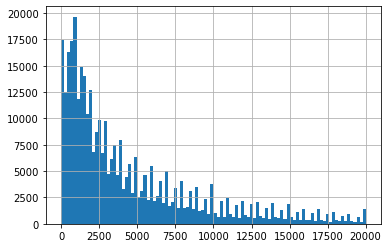

In [22]:
df['price'].hist(bins=100)

Большая часть объявлений находится в ценовом сегменте от 0 до 2500, рассмотрим самый низ этого диапазона подробнее.

<AxesSubplot:>

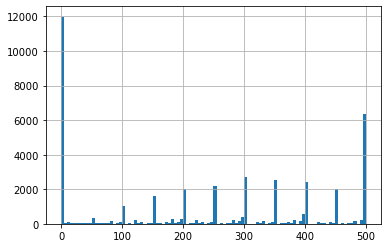

In [23]:
df['price'].hist(bins=100, range=(0, 500))

Наибольшие вопросы вызывают цены в 0 евро, я думаю стоит отбросить все объявления с ценой ниже 100 евро, это могут быть как варианты аренды или просто ошибочно заполненные данные, обучению модели они не помогут.

In [24]:
len(df[df['price'] <100])

13314

In [25]:
df.shape

(354369, 11)

In [26]:
df.drop(df[df['price'] < 100].index, inplace=True)

In [27]:
df.shape

(341055, 11)

Нижний порог мощности двигателя ограничим 25 л.с.

In [28]:
df.query('power < 25')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown,2016-03-24 00:00:00
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown,2016-03-11 00:00:00
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no,2016-03-15 00:00:00
37,1500,other,2016,unknown,0,kangoo,150000,gasoline,renault,no,2016-03-28 00:00:00
54,4700,wagon,2005,manual,0,signum,150000,other,opel,no,2016-03-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
354338,180,other,1995,unknown,0,other,125000,petrol,opel,unknown,2016-03-31 00:00:00
354346,2600,other,2005,auto,0,c_klasse,150000,other,mercedes_benz,unknown,2016-03-07 00:00:00
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no,2016-04-02 00:00:00
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,2016-03-27 00:00:00


In [29]:
df.shape

(341055, 11)

In [30]:
df.drop(df[df['power'] < 25].index, inplace=True)

In [31]:
df.shape

(305500, 11)

Оставим только автомобили выпущенные после Второй мировой войны и не позднее года выгрузки данных.

In [32]:
df.drop(df[df['registration_year'] <= 1945].index, inplace=True)
df.drop(df[df['registration_year'] > 2016].index, inplace=True)

In [33]:
df.shape

(295210, 11)

Теперь можно избавиться от оставшихся дубликатов.

df.duplicated().sum()

In [34]:
df = df.drop_duplicates()

In [35]:
df.shape

(283624, 11)

Осталось только закодировать категориальные признаки.  
Для трех из четырех моделей подойдет порядковое кодирование, но линейная модель должна показать лучшие результаты при прямом кодировании.  
Второй вариант сохраним в переменной df_copy.

In [36]:
df_copy = pd.get_dummies(df, drop_first=True)

In [37]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired', 'date_created']

In [38]:
encoder = OrdinalEncoder()

In [39]:
df[cat_features] = encoder.fit_transform(df[cat_features])

In [40]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created
1,18300,2.0,2011,1.0,190,166.0,125000,2.0,1.0,2.0,91.0
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0,81.0
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0,84.0
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0,98.0
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,2.0,102.0


In [41]:
df[cat_features] = df[cat_features].astype('int')

## Выбор модели

Целевой признак лежит в столбце 'price'.  
Поскольку выбирать модель будем методом кросс-валидации, разбиваем датасет только на обучающую и тестовую выборки в соотношении 3 к 1.

In [42]:
features = df.drop('price', axis=1)
target = df['price']

In [43]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

Для начала попробуем простые модели, начнем с дерева решений.

In [44]:
model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, random_state=12345)
cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=4).mean()

-1964.471102690551

In [45]:
%%time
model.fit(features_train, target_train)

Wall time: 415 ms


DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, random_state=12345)

In [46]:
%%time
model.predict(features_train)

Wall time: 30 ms


array([2716.9       , 5233.09672131,  987.08114721, ..., 2331.92758827,
       1633.32871566, 2179.10553337])

Значение RMSE попадает в целевой диапазон.   
На моем локальном устройстве обучение зани предсказания заняли 460 миллисекунд и 26 миллисекунд соответсвенно, возьмем эти времена за точку отсчета.

Теперь попробуем линейную модель Lasso.  
Используем признаки из df_copy, также промасштабируем численные признаки.

In [47]:
features1 = df_copy.drop('price', axis=1)
target1 = df_copy['price']
features_train1, features_test1, target_train1, target_test1 = train_test_split(features1, target1, test_size=0.25, random_state=12345)

In [48]:
numeric = ['registration_year', 'power']
scaler = StandardScaler()
scaler.fit(features_train1[numeric])

StandardScaler()

In [49]:
features_train1[numeric] = scaler.transform(features_train1[numeric])
features_test1[numeric] = scaler.transform(features_test1[numeric])

In [ ]:
model = Lasso(random_state=12345)
cross_val_score(model, features_train1, target_train1, scoring='neg_root_mean_squared_error', cv=4).mean()

In [ ]:
%%time
model.fit(features_train1, target_train1)

In [ ]:
%%time
model.predict(features_train1)

RMSE выше 2500, скорость обучения более 13 секунд, предсказание 296 миллисекунд. Прямое кодирование данного датасета создает слишком большое количество столбцов, увеличивая время обучения. Эта модель точно не подойдет.

Теперь рассмотрим два градиентных бустинга, начем с LightGBM.

In [ ]:
model = LGBMRegressor(n_estimators=50, max_depth=15, num_leaves=50, random_state=12345)
cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=4).mean()

In [ ]:
%%time
model.fit(features_train, target_train)

In [ ]:
%%time
model.predict(features_train)

Результат RMSE заметно лучше, чем у дерева решений, время обучения в 343 миллисекунды еще быстрее, предсказание занимает 98 миллисекунд, что немного дольше.

In [ ]:
model = CatBoostRegressor(loss_function='RMSE', max_depth=15, iterations=10, random_state=12345)
cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=4).mean()

In [ ]:
%%time
model.fit(features_train, target_train)

In [ ]:
%%time
model.predict(features_train)

RMSE на уровне результата LightGBM, но скорость обучения оставляет желать лучшего(3,83 секунды), хотя предсказания эта модель дает быстрее всех(22 миллисекунды).  

Остановим выбор на LightGBM, показавшей лучший результат в двух из трех категорий, осталось только проверить модель на тестовой выборке.

In [ ]:
model = LGBMRegressor(n_estimators=50, max_depth=15, num_leaves=50, n_jobs=10, random_state=12345)

In [ ]:
%%time
model.fit(features_train, target_train)

In [ ]:
%%time
predictions = model.predict(features_test)

In [ ]:
mean_squared_error(target_test, predictions, squared=False)

Обучение и предсказание занимают меньше секунды, RMSE меньше 2500. Успех!

## Общий вывод
Предоставленные данные позволяют выполнить поставленную задачу.  
В рамках предобработки были удалены неинформативные признаки, пропуски в категориальных признаках заполнены, аномалии в количественных признаках отброшены.  
Были выбраны и проверены методом кросс-валидации четыре модели.  
Лучшие результаты показал градиентный бустинг LightGBM, также стоит отметить неплохией показатели дерева решений.  
Хотя это не показано в итоговом варианте работы, CatBoost стоит выделить за минимальные требования к подготовке признаков, он запускался и без кодирования категориальных признаков. 